In [2]:
%matplotlib inline

import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

import scanpy as sc

import sys
sys.path.append('/home/ngr4/project')
import scnd.scripts.data as scnddata
import bbknn
import phate

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [3]:
if False:
    # create merged adata for separately imputed adatas (wt/ctrl)
    scnddata.merge_imputed(adata_out='/home/ngr4/project/scnd/data/processed/hum_imputed_210920.h5ad')

In [4]:
adata = scnddata.load_human_redo(imputed=False)

# Cluster vs. markers

Compare cluster to provided set of markers

In [4]:
# markersoi = {
#     'GC': ['GABRA6', 'SLC17A7'], 
#     'UBC': ['SLC17A6', 'EOMES'], 
#     'PC': ['ATP2A3', 'CALB1', 'CA8', 'PPP1R17', 'SLC1A6'], 
#     'IN': ['GAD1', 'GAD2', 'NTN1', 'MEGF10'], 
#     'AS': ['ALDH1L1', 'AQP4'],
#     'GDF10', 'HOPX', 'OLIG1', 'OLIG2', 'PDGFRA',
#     'HAPLN2', 'MAG', 'MOG', 'OPALIN', 'C1QB', 
#     'CX3CR1', 'DOCK2', 'P2RY12', 'FLT1', 'RGS5', 'DCN', 'LUM', 'KDR'
#            }

markersoi = [
    'GABRA6', 'SLC17A7', 'SLC17A6', 'EOMES', 
    'ATP2A3', 'CALB1', 'CA8', 'PPP1R17', 'SLC1A6', 
    'GAD1', 'GAD2', 'NTN1', 'MEGF10', 'ALDH1L1', 'AQP4',
    'GDF10', 'HOPX', 'OLIG1', 'OLIG2', 'PDGFRA',
    'HAPLN2', 'MAG', 'MOG', 'OPALIN', 'C1QB', 
    'CX3CR1', 'DOCK2', 'P2RY12', 'FLT1', 'RGS5', 'DCN', 'LUM', 'KDR'
]

# set fp for scanpy
sc.settings.figdir = '/home/ngr4/project/scnd/results/'

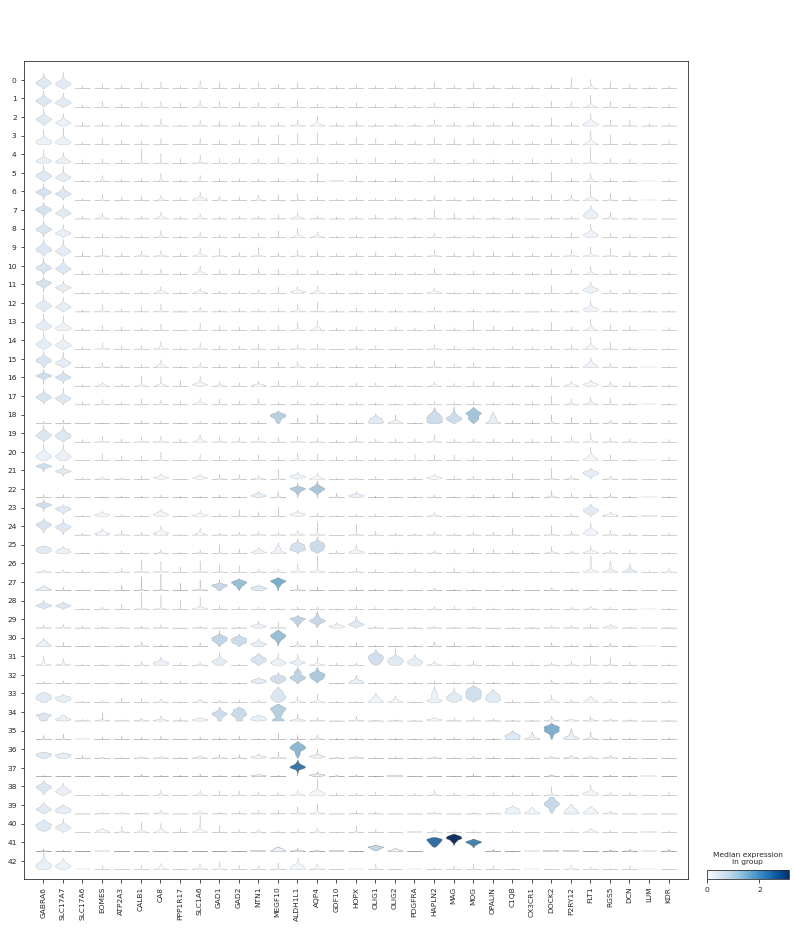

In [5]:
sc.pl.StackedViolin(adata, 
                    markersoi,
                    groupby='leiden', 
                    use_raw=False, 
                    layer='imputed').savefig(
    '/home/ngr4/project/scnd/results/violin_hum_redo_ctype_annotation.pdf', 
    bbox_inches='tight', 
    dpi=300
)

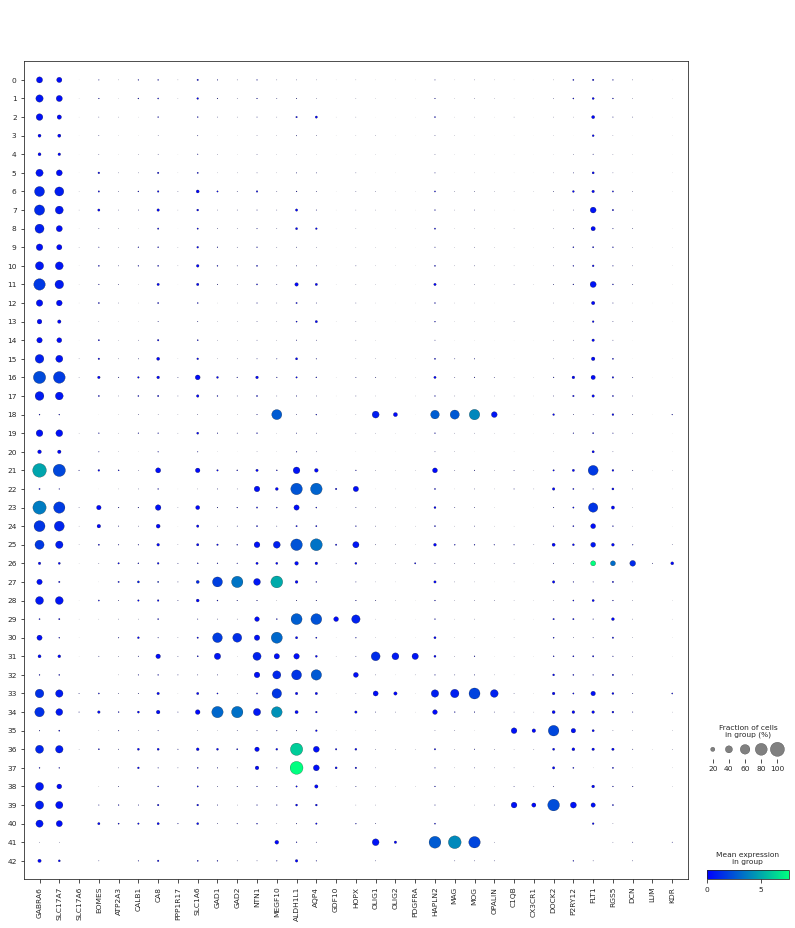

In [6]:
sc.pl.DotPlot(adata, 
                    markersoi,
                    groupby='leiden', 
                    use_raw=True).savefig(
    '/home/ngr4/project/scnd/results/dotplot_hum_redo_ctype_annotation.pdf', 
    bbox_inches='tight', 
    dpi=300
)

In [7]:
pfp = '/home/ngr4/project/scnd/results/'

In [8]:
for groupby in ['batch', 'leiden', 'genotype']:
    adata.obs.groupby(groupby).mean().to_csv(os.path.join(pfp, 'md_hum_redo_by_{}.csv'.format(groupby)))

In [9]:
for groupby in ['batch']:
    adata.obs.groupby(groupby).sum().to_csv(os.path.join(pfp, 'md_hum_redo_SUM_by_{}.csv'.format(groupby)))

#### embeddings

To help with annotation, label by cluster

In [11]:
l='0'

In [15]:
x, y = np.mean(adata[adata.obs['leiden']==l, :].obsm['X_umap'], 0)

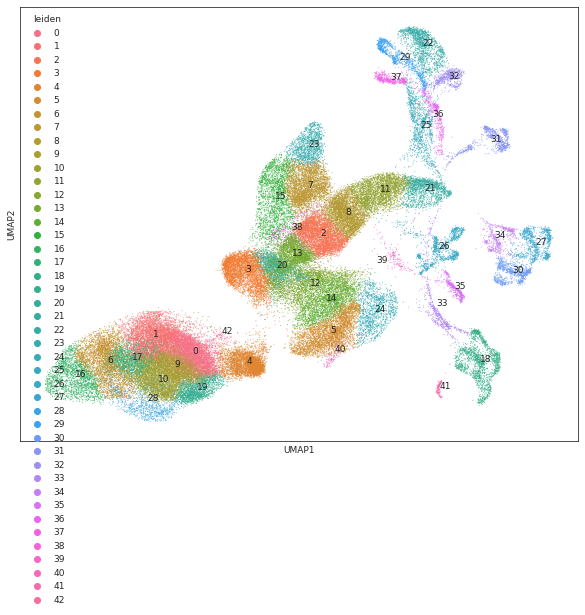

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.scatterplot(x=adata.obsm['X_umap'][:, 0],
                y=adata.obsm['X_umap'][:, 1],
                hue=adata.obs['leiden'],
                linewidth=0,
                alpha=0.8,
                s=1,
                rasterized=True,
                ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

for l in adata.obs['leiden'].unique():
    x, y = np.mean(adata[adata.obs['leiden']==l, :].obsm['X_umap'], 0)
    ax.text(x, y, l)
    
fig.savefig('/home/ngr4/project/scnd/results/umap_hum_redo_leiden_ctype_annotation.pdf', bbox_inches='tight', dpi=600)

## transfer labels

In a previous iteration, there were cell type annotations. These could be used but it may be a  bit messy... e.g., imagine that a particular new cluster (like cluster 0) has a mixture of cell types from the old dataset... is it okay to just pick the majority one? What if some of the new clusters have much higher proportion of new samples' cells... anyway, we can do it but technically, it changes the methods

In [10]:
adata

AnnData object with n_obs × n_vars = 79928 × 28971
    obs: 'batch', 'Sample', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'source'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    layers: 'imputed'